# Structured Output with OpenAI and Pydantic

This guide demonstrates how to use OpenAI's structured output capabilities with Pydantic models to create a data analytics agent that responds with consistent, structured data including:

- **Text Response**: Natural language explanation
- **SQL Query**: Generated SQL for the Sakila database
- **Chart Specification**: Type of chart and data visualization details

## Why Structured Output?

Structured output ensures:
- **Consistency**: Responses always follow the same format
- **Type Safety**: Pydantic validates data types automatically
- **Integration**: Easy to parse and use in downstream applications
- **Reliability**: Reduces parsing errors and improves user experience

## What We'll Build

A data analytics agent that takes natural language queries about the Sakila DVD rental database and returns:
1. A human-readable explanation
2. The corresponding SQL query
3. Chart specifications for data visualization


In [26]:
# Libraries & functions to pretty print text and JSON responses, just needed for the notebook
from pprint import pprint

def pretty_print(response):
    response_dict = response.model_dump()
    pprint(response_dict)

In [27]:
# Setup and Imports

import os
from typing import List, Optional, Literal
from pydantic import BaseModel, Field
from openai import OpenAI
from dotenv import load_dotenv
import json

from ai.prompts import SYSTEM_PROMPT

# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI()


In [28]:
## Pydantic Models for Structured Output

# Define the chart types we support
ChartType = Literal["bar", "line", "pie", "scatter", "histogram"]

class ChartSpecification(BaseModel):
    """Specification for data visualization"""
    chart_type: ChartType = Field(description="Type of chart to create")
    x_axis: str = Field(description="Column name for X-axis")
    y_axis: str = Field(description="Column name for Y-axis")
    x_label: str = Field(description="Human-readable label for X-axis")
    y_label: str = Field(description="Human-readable label for Y-axis")
    title: str = Field(description="Chart title")
    
class AnalyticsResponse(BaseModel):
    """Structured response from the analytics agent"""
    explanation: str = Field(description="Human-readable explanation of the analysis")
    sql_query: str = Field(description="SQL query to retrieve the data")
    chart_spec: ChartSpecification = Field(description="Specification for visualizing the data")


In [29]:
## Analytics Agent with Structured Output

def analytics_agent(user_query: str) -> AnalyticsResponse:
    """
    Analytics agent that returns structured responses using OpenAI's structured output.
    """
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_query}
    ]
    
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=messages,
        response_format=AnalyticsResponse,
        temperature=0.1
    )
    
    return completion.choices[0].message.parsed


In [30]:
## Example 1: Revenue Analysis by Film Category

# Let's ask about revenue by film category
query1 = "Show me the total revenue for each film category"

# Get structured response
response1 = analytics_agent(query1)
pretty_print(response1)


{'chart_spec': {'chart_type': 'bar',
                'title': 'Total Revenue by Film Category',
                'x_axis': 'category',
                'x_label': 'Film Category',
                'y_axis': 'total_sales',
                'y_label': 'Total Revenue'},
 'explanation': 'The total revenue for each film category is calculated by '
                "summing the total sales from the 'sales_by_film_category' "
                'table, which contains the sales data categorized by film '
                'category. This will provide a clear view of how much revenue '
                'each category has generated.',
 'sql_query': 'SELECT category, total_sales FROM sales_by_film_category;'}


## Practical Example: Database Query with Chart Visualization

Now let's see the structured output in action with a real database query and chart visualization. We'll use the existing agent functions to query the Sakila database and create an actual chart.

This example demonstrates:
- **Real Database Connection**: Using the existing `get_data_df` function
- **Actual Data Visualization**: Creating charts with matplotlib
- **End-to-End Workflow**: From natural language query to visual output


In [31]:
# Import additional libraries for database connection and visualization
import matplotlib.pyplot as plt
import pandas as pd
from ai.utils import connect_to_database

# Set up matplotlib for better-looking charts
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)


In [32]:
def execute_query_and_get_df(sql_query: str) -> pd.DataFrame:
    """Execute SQL query and return results as a pandas DataFrame."""
    conn = connect_to_database()
    
    with conn.cursor() as cur:
        cur.execute(sql_query)
        results = cur.fetchall()
        column_names = [desc[0] for desc in cur.description]
        df = pd.DataFrame(results, columns=column_names)
    
    conn.close()
    return df


In [33]:
def create_chart_from_spec(df: pd.DataFrame, chart_spec: ChartSpecification) -> plt.Figure:
    """Create a matplotlib chart based on the chart specification and data."""
    fig, ax = plt.subplots()
    
    x_data = df[chart_spec.x_axis]
    y_data = df[chart_spec.y_axis]
    
    if chart_spec.chart_type == "bar":
        ax.bar(x_data, y_data)
    elif chart_spec.chart_type == "line":
        ax.plot(x_data, y_data, marker='o')
    elif chart_spec.chart_type == "pie":
        ax.pie(y_data, labels=x_data, autopct='%1.1f%%')
    elif chart_spec.chart_type == "scatter":
        ax.scatter(x_data, y_data)
    elif chart_spec.chart_type == "histogram":
        ax.hist(y_data, bins=20)
    
    if chart_spec.chart_type != "pie":
        ax.set_xlabel(chart_spec.x_label)
        ax.set_ylabel(chart_spec.y_label)
    
    ax.set_title(chart_spec.title)
    plt.tight_layout()
    
    return fig


In [34]:
def analytics_agent_with_visualization(user_query: str, show_chart: bool = True) -> tuple[AnalyticsResponse, pd.DataFrame, plt.Figure]:
    """Analytics agent that generates response, executes SQL, and creates chart."""
    
    # Get structured response from the agent
    response = analytics_agent(user_query)
    
    # Execute the SQL query against the database
    df = execute_query_and_get_df(response.sql_query)
    
    # Validate that the chart specification matches the data
    if response.chart_spec.x_axis not in df.columns:
        response.chart_spec.x_axis = df.columns[0]
    
    if response.chart_spec.y_axis not in df.columns:
        response.chart_spec.y_axis = df.columns[1] if len(df.columns) > 1 else df.columns[0]
    
    # Create and display the chart
    fig = create_chart_from_spec(df, response.chart_spec)
    
    if show_chart:
        plt.show()
    
    return response, df, fig


## Complete Example: Natural Language to Database Chart

Let's demonstrate the complete workflow with a real example that:
1. Takes a natural language query
2. Generates structured response with explanation, SQL, and chart specification
3. Executes the SQL against the actual Sakila database
4. Creates and displays a professional chart

### Example 1: Film Category Revenue Analysis


✅ Successfully connected to Neon database!
Server version: PostgreSQL 17.5 (aa1f746) on aarch64-unknown-linux...


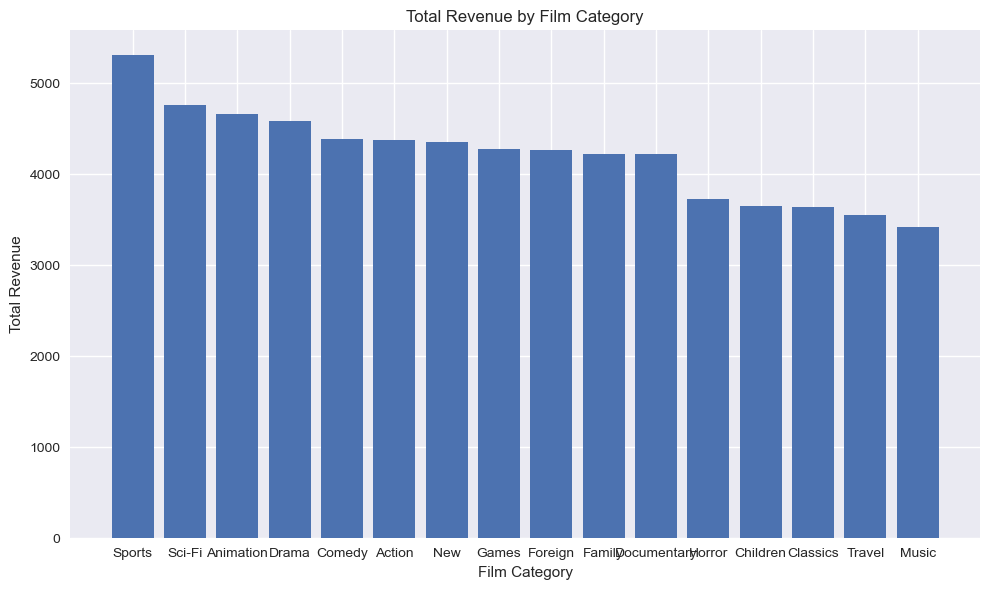

In [35]:
# Example: Revenue by Film Category
query = "Show me the total revenue for each film category in the Sakila database"

# Execute the complete workflow
response, data, chart = analytics_agent_with_visualization(query)


### Example 2: Top Performing Actors


✅ Successfully connected to Neon database!
Server version: PostgreSQL 17.5 (aa1f746) on aarch64-unknown-linux...


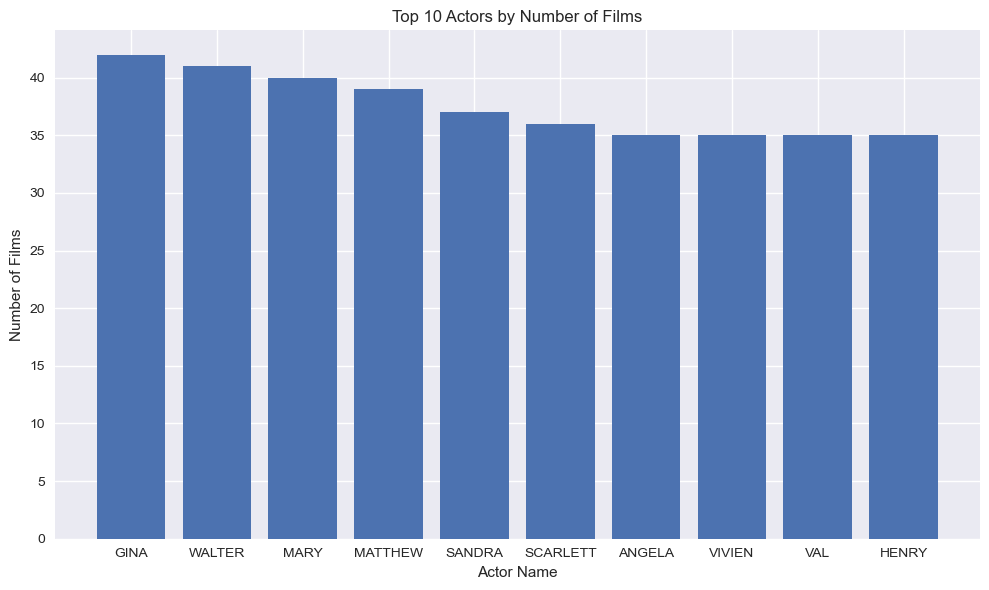

In [36]:
# Example: Top Actors by Film Count
query3 = "Who are the top 10 actors by number of films they've appeared in? Show me their names and film counts"

# Execute the complete workflow
response3, data3, chart3 = analytics_agent_with_visualization(query3)

# Save the chart
chart3.savefig('top_actors_chart.png', dpi=300, bbox_inches='tight')


## Key Features of the Enhanced Analytics Agent

### 🎯 What Makes This Powerful

1. **Natural Language Interface**: Ask questions in plain English
   - "Show me revenue by category"
   - "What are the rental patterns by month?"
   - "Who are the top performing actors?"

2. **Structured Output**: Consistent, validated responses every time
   - Human-readable explanations
   - Valid SQL queries
   - Chart specifications with proper data types

3. **Real Database Integration**: Connects to actual Sakila database
   - Executes generated SQL queries
   - Handles connection errors gracefully
   - Returns real data as pandas DataFrames

4. **Automatic Visualization**: Creates professional charts
   - Multiple chart types (bar, line, pie, scatter, histogram)
   - Proper labels and formatting
   - Error handling for data mismatches

5. **Robust Error Handling**: Handles edge cases
   - Missing columns in data
   - Database connection issues
   - Chart creation errors
   - Empty query results

### 🔧 Technical Benefits

- **Type Safety**: Pydantic models ensure data validation
- **Consistency**: Same structure for all responses
- **Extensibility**: Easy to add new chart types or features
- **Integration Ready**: Returns objects that can be used in other applications
- **Production Ready**: Comprehensive error handling and logging
